# Analyse Exploratoire

### Import des modules

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import shap
import time


# Modélisation 

### Import des modules 

In [12]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [13]:
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

building_consumption = joblib.load("building.joblib")
results = []
timing_results = []

In [14]:
# Voir le nombre de colonne non numérique

non_numeric_cols = building_consumption.select_dtypes(exclude=["number"]).columns

for col in non_numeric_cols:
    unique_count = building_consumption[col].nunique()
    print(f"{col} : {unique_count} valeur(s) unique(s)")


BuildingType : 5 valeur(s) unique(s)
PrimaryPropertyType : 21 valeur(s) unique(s)
Neighborhood : 19 valeur(s) unique(s)
LargestPropertyUseType : 55 valeur(s) unique(s)
SecondLargestPropertyUseType : 48 valeur(s) unique(s)
ThirdLargestPropertyUseType : 39 valeur(s) unique(s)


In [15]:
mapping = {
    'Office': 'Commercial',
    'Non-Refrigerated Warehouse': 'Industrial',
    'Refrigerated Warehouse': 'Industrial',
    'Distribution Center': 'Industrial',
    'Retail Store': 'Retail',
    'Supermarket/Grocery Store': 'Retail',
    'Restaurant': 'Retail',
    'Strip Mall': 'Retail',
    'Hotel': 'Lodging',
    'Residence Hall/Dormitory': 'Lodging',
    'Senior Care Community': 'Lodging',
    'College/University': 'Education',
    'K-12 School': 'Education',
    'Adult Education': 'Education',
    'Medical Office': 'Healthcare',
    'Hospital (General Medical & Surgical)': 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient': 'Healthcare',
    'Other/Specialty Hospital': 'Healthcare',
    'Library': 'Public',
    'Worship Facility': 'Public',
    'Police Station': 'Public',
    'Courthouse': 'Public',
    'Fire Station': 'Public',
    'Prison/Incarceration': 'Public',
    'Social/Meeting Hall': 'Public',
    'Movie Theater': 'Entertainment',
    'Performing Arts': 'Entertainment',
    'Other - Entertainment/Public Assembly': 'Entertainment',
    'Fitness Center/Health Club/Gym': 'Recreation',
    'Other - Recreation': 'Recreation',
    'Manufacturing/Industrial Plant': 'Industrial',
    'Self-Storage Facility': 'Storage',
    'Parking': 'Infrastructure',
    'Bank Branch': 'Commercial',
    'Financial Office': 'Commercial',
    'Automobile Dealership': 'Commercial',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Commercial',
    'Food Service': 'Retail',
    'Pre-school/Daycare': 'Education',
    'Lifestyle Center': 'Retail',
    'Data Center': 'Infrastructure',
    'Swimming Pool': 'Recreation',
    'Bar/Nightclub': 'Entertainment',
    'Food Sales': 'Retail',
    'Convenience Store without Gas Station': 'Retail',
    'Enclosed Mall': 'Retail',
    'Vocational School': 'Education',
    'Pre-school/Daycare': 'Education',
    'Other - Restaurant/Bar': 'Entertainment',
    'Other - Public Services': 'Public',
    'Other - Services': 'Service',
    'Other - Lodging/Residential': 'Lodging',
    'Social/Meeting Hall': 'Public',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Service',
    'Gas Station with Convenience Store': 'Retail',
    'Ice Rink': 'Recreation',
    'Swimming Pool': 'Recreation',
    'Bar/Nightclub': 'Entertainment',
    'Food Service': 'Retail',
    'Convenience Store without Gas Station': 'Retail',
    'Fast Food Restaurant': 'Retail',
    'Pre-school/Daycare': 'Education',
    'Vocational School': 'Education',
    'Other - Restaurant/Bar': 'Entertainment',
    'Other - Entertainment/Public Assembly': 'Entertainment',
    'Other - Education': 'Education',
    'Other - Services': 'Service',
    'Other - Technology/Science': 'Service',
    'Other - Recreation': 'Recreation',
    'Other - Utility': 'Infrastructure',
    'Other/Specialty Hospital': 'Healthcare',
    'Social/Meeting Hall': 'Public',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Service',
    'Self-Storage Facility': 'Storage',
    'Manufacturing/Industrial Plant': 'Industrial',
    'Strip Mall': 'Retail',
    'Other': 'Other',
}

# Création de la colonne avec le mapping pour regrouper
building_consumption['LargestPropertyCategory'] = building_consumption['LargestPropertyUseType'].map(mapping).fillna('Other')
building_consumption['SecondLargestPropertyCategory'] = building_consumption['SecondLargestPropertyUseType'].map(mapping).fillna('Other')
building_consumption['ThirdLargestPropertyCategory'] = building_consumption['ThirdLargestPropertyUseType'].map(mapping).fillna('Other')

# Supprimer les colonnes traités
building_consumption.drop(columns=['LargestPropertyUseType'], inplace=True)
building_consumption.drop(columns=['SecondLargestPropertyUseType'], inplace=True)
building_consumption.drop(columns=['ThirdLargestPropertyUseType'], inplace=True)

In [16]:
property_type_mapping = {
    'Small- and Mid-Sized Office': 'Office',
    'Large Office': 'Office',
    'Warehouse': 'Industrial',
    'Refrigerated Warehouse': 'Industrial',
    'Distribution Center': 'Industrial',
    'Retail Store': 'Retail',
    'Supermarket / Grocery Store': 'Retail',
    'Restaurant': 'Retail',
    'Hotel': 'Lodging',
    'Residence Hall': 'Lodging',
    'Senior Care Community': 'Lodging',
    'University': 'Education',
    'K-12 School': 'Education',
    'Medical Office': 'Healthcare',
    'Hospital': 'Healthcare',
    'Laboratory': 'Healthcare',
    'Self-Storage Facility': 'Storage',
    'Worship Facility': 'Public',
    'Mixed Use Property': 'Mixed',
    'Low-Rise Multifamily': 'Residential',
    'Other': 'Other'
}

building_consumption['PrimaryPropertyCategory'] = building_consumption['PrimaryPropertyType'].map(property_type_mapping).fillna('Other')

# Supprimer les colonnes traités
building_consumption.drop(columns=['PrimaryPropertyType'], inplace=True)

In [17]:
# Voir le nombre de colonne non numérique

non_numeric_cols = building_consumption.select_dtypes(exclude=["number"]).columns

for col in non_numeric_cols:
    unique_count = building_consumption[col].nunique()
    print(f"{col} : {unique_count} valeur(s) unique(s)")


BuildingType : 5 valeur(s) unique(s)
Neighborhood : 19 valeur(s) unique(s)
LargestPropertyCategory : 13 valeur(s) unique(s)
SecondLargestPropertyCategory : 13 valeur(s) unique(s)
ThirdLargestPropertyCategory : 13 valeur(s) unique(s)
PrimaryPropertyCategory : 11 valeur(s) unique(s)


In [18]:

# # Conversion des colonnes non numérique

# # Get Dummies pour Building Type (5 type)

# building_consumption = pd.get_dummies(building_consumption, columns=['BuildingType'], drop_first=True)

# # Get Dummies pour Neighborhood  (19 type)

# building_consumption = pd.get_dummies(building_consumption, columns=['Neighborhood'], drop_first=True)


# # Get Dummies pour LargestPropertyCategory, SecondLargestPropertyUseType, ThirdLargestPropertyUseType  (13 type)

# building_consumption = pd.get_dummies(
#     building_consumption,
#     columns=[
#         'LargestPropertyCategory',
#         'SecondLargestPropertyCategory',
#         'ThirdLargestPropertyCategory'
#     ],
#     drop_first=True
# )

# # Get Dummies pour PrimaryPropertyCategory  (11 type)
# building_consumption = pd.get_dummies(building_consumption, columns=['PrimaryPropertyCategory'], drop_first=True)




In [19]:
# Colonnes avec des catégories
cat_cols = [
    'BuildingType',
    'Neighborhood',
    'LargestPropertyCategory',
    'SecondLargestPropertyCategory',
    'ThirdLargestPropertyCategory',
    'PrimaryPropertyCategory'
]

# Colonnes avec des nombres

num_cols = [
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'ENERGYSTARScore',
    'electricity',
    'natural_gas',
    'steam'
]

# Preprocess pour transformer les colonnes

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [20]:
# Drop des deux targets conso et energie

X = building_consumption.drop(columns=["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"])

# Valeurs de la target

y = building_consumption.loc[X.index, "TotalGHGEmissions"]

In [21]:
# Split du jeu de données en deux partie
    # Une pour le train 80% des données
    # Une pour le test 20% des données

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [22]:

def evaluate_model(name, model_or_class, X, y, model_params=None, cv=5):
    if callable(model_or_class):
        model = model_or_class(**(model_params or {}))
    else:
        model = model_or_class

    scoring = {
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error'
    }

    results_cv = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    
    r2_train = np.max(results_cv['train_r2'])
    r2_test = np.max(results_cv['test_r2'])
    mae_train = -np.min(results_cv['train_mae'])
    mae_test = -np.min(results_cv['test_mae'])
    rmse_train = -np.min(results_cv['train_rmse'])
    rmse_test = -np.min(results_cv['test_rmse'])
    predictTime = np.mean(results_cv['score_time'])
    trainTime = np.mean(results_cv['fit_time'])


    print(f"Model: {name}")
    print(f"→ R2 (train): {r2_train:.3f} | R2 (test): {r2_test:.3f}")
    print(f"→ MAE (train): {mae_train:.2f} | MAE (test): {mae_test:.2f}")
    print(f"→ RMSE (train): {rmse_train:.2f} | RMSE (test): {rmse_test:.2f}")
    print(f"→ Time Predict : { (predictTime * 1000):.2f}")
    print(f"→ Time Train : { (trainTime * 1000):.2f}")
    
    results.append({
        'Model': name,
        'R2 Train': round(r2_train, 3),
        'R2 Test': round(r2_test, 3),
        'MAE Train': round(mae_train, 2),
        'MAE Test': round(mae_test, 2),
        'RMSE Train': round(rmse_train, 2),
        'RMSE Test': round(rmse_test, 2),
        'Time Predict': (predictTime * 1000),
        'Time Train': (trainTime * 1000) 
    })



In [23]:
def measureTime(name, model_or_class, X, y, params=None):
    if callable(model_or_class):
        model = model_or_class(**(params or {}))
    else:
        model = model_or_class

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Temps d'entraînement
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Temps de prédiction
    start_predict = time.time()
    model.predict(X_test)
    end_predict = time.time()
    predict_time = end_predict - start_predict

    predictSample = (predict_time * 1000) / len(X_test)

    timing_results.append({
        'Model': name,
        'Train Time': train_time,
        'Predict Time': predict_time,
        'Predict Time per Sample': predictSample
    })

In [24]:

# Dummy Regressor

model = DummyRegressor()

evaluate_model("DummyRegressor", model, X, y)
measureTime("DummyRegressor", model, X, y)

Model: DummyRegressor
→ R2 (train): 0.000 | R2 (test): -0.010
→ MAE (train): 1.12 | MAE (test): 1.38
→ RMSE (train): 1.41 | RMSE (test): 1.69
→ Time Predict : 1.30
→ Time Train : 1.77


In [25]:

# Regresion Linéaire

model = LinearRegression()

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])

evaluate_model("LinearRegression", pipe, X, y)
measureTime("LinearRegression", pipe, X, y)


Model: LinearRegression
→ R2 (train): 0.845 | R2 (test): 0.779
→ MAE (train): 0.42 | MAE (test): 0.53
→ RMSE (train): 0.58 | RMSE (test): 0.74
→ Time Predict : 5.67
→ Time Train : 22.58


In [26]:

# SVR

model = SVR()

params = {
    'n_estimators': 100,
    'max_depth': 3,
    'random_state': 42
}

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])

evaluate_model("SVR", pipe, X, y, params)
measureTime("SVR", pipe, X, y, )



Model: SVR
→ R2 (train): 0.890 | R2 (test): 0.808
→ MAE (train): 0.30 | MAE (test): 0.48
→ RMSE (train): 0.49 | RMSE (test): 0.70
→ Time Predict : 17.54
→ Time Train : 68.63


In [27]:
# Random Forest

model = RandomForestRegressor()

params = {
    'n_estimators': 100,
    'max_depth': 3,
    'random_state': 42
}

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])

evaluate_model("RandomForestRegressor", pipe, X, y, params)
measureTime("RandomForestRegressor", pipe, X, y, params)

Model: RandomForestRegressor
→ R2 (train): 0.971 | R2 (test): 0.760
→ MAE (train): 0.18 | MAE (test): 0.54
→ RMSE (train): 0.25 | RMSE (test): 0.72
→ Time Predict : 15.03
→ Time Train : 1414.23


In [28]:

# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor


model = GradientBoostingRegressor(random_state=42)


params = {
   'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])


evaluate_model("GradientBoostingRegressor", pipe, X, y, params)
measureTime("GradientBoostingRegressor", pipe, X, y, params)

Model: GradientBoostingRegressor
→ R2 (train): 0.908 | R2 (test): 0.804
→ MAE (train): 0.33 | MAE (test): 0.49
→ RMSE (train): 0.44 | RMSE (test): 0.68
→ Time Predict : 5.98
→ Time Train : 271.98


In [29]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

model = XGBRegressor(random_state=42, verbosity=0)

# Définir les hyperparamètres à tester
params = {
   'regressor__n_estimators': [100, 200],
   'regressor__learning_rate': [0.05, 0.1],
   'regressor__max_depth': [3, 5],
   'regressor__subsample': [0.8, 1.0]
}

# Construire le pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])

# Évaluer le modèle
evaluate_model("XGBoost", pipe, X, y, params)
measureTime("XGBoost", pipe, X, y, params)


Model: XGBoost
→ R2 (train): 0.997 | R2 (test): 0.772
→ MAE (train): 0.06 | MAE (test): 0.51
→ RMSE (train): 0.09 | RMSE (test): 0.71
→ Time Predict : 9.67
→ Time Train : 350.40


### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.

In [30]:

params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0]
}

model = GradientBoostingRegressor(random_state=42)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', model)
])

grid = GridSearchCV(pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Meilleur R2 Score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

print(f"→ R2 (train): {r2_score(y_train, y_pred_train):.3f} | R2 (test): {r2_score(y_test, y_pred_test):.3f}")
print(f"→ MAE (train): {mean_absolute_error(y_train, y_pred_train):.2f} | MAE (test): {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"→ RMSE (train): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f} | RMSE (test): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleur R2 Score: 0.7969471012064325
→ R2 (train): 0.901 | R2 (test): 0.850
→ MAE (train): 0.32 | MAE (test): 0.38
→ RMSE (train): 0.44 | RMSE (test): 0.52


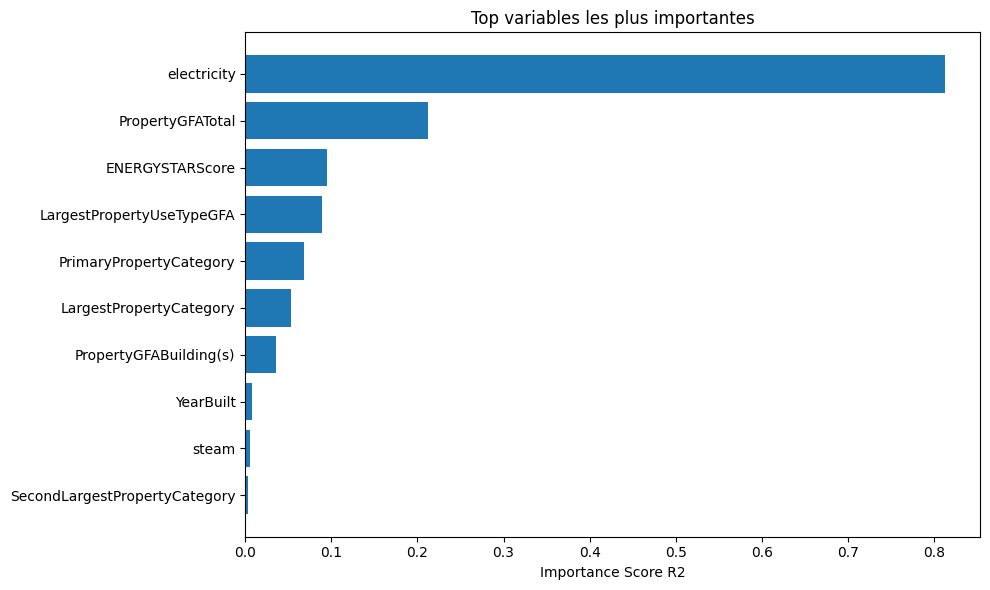

In [31]:
best_model = grid.best_estimator_

result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=30,
    random_state=42,
    scoring='r2'
)

importances = result.importances_mean
feature_names = X_test.columns

top = 10
sorted_idx = importances.argsort()[::-1][:top]

plt.figure(figsize=(10, 6))
plt.barh(range(top), importances[sorted_idx])
plt.yticks(range(top), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance Score R2")
plt.title("Top variables les plus importantes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


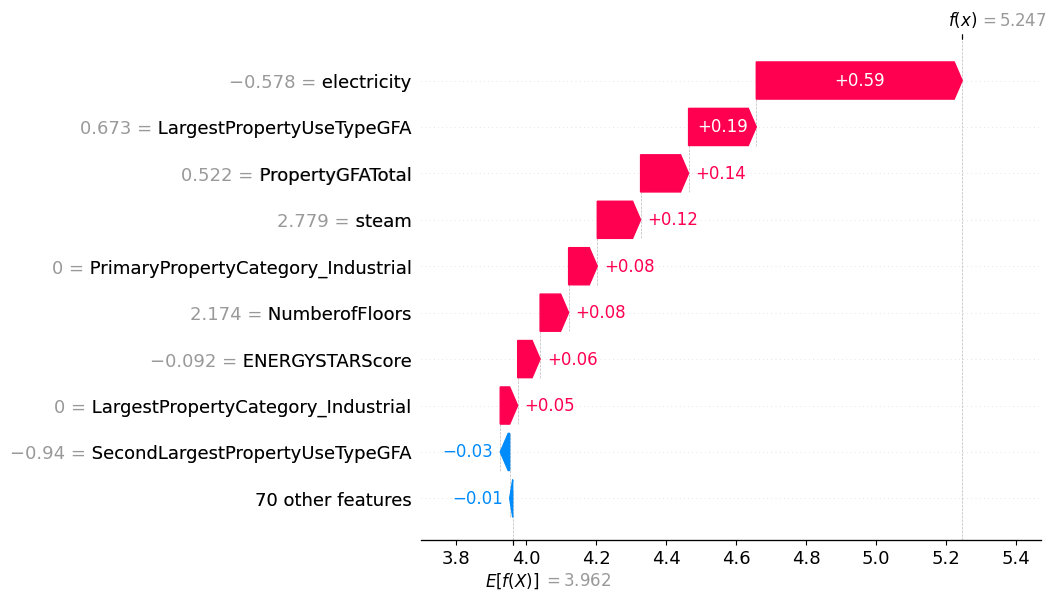

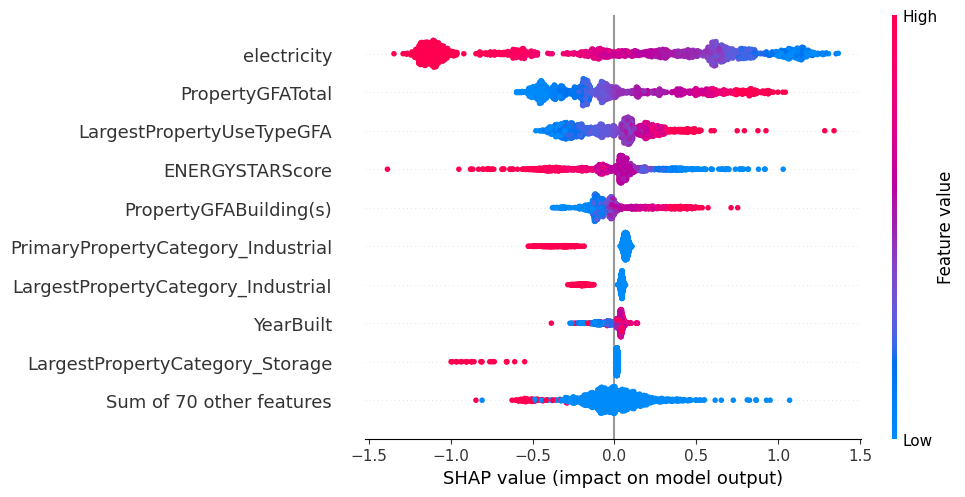

In [32]:
import shap

model = best_model.named_steps['regressor']
preprocessor = best_model.named_steps['preprocessing']

X_proc = preprocessor.transform(X)

features = np.concatenate([
    preprocessor.named_transformers_['num'].get_feature_names_out(),
    preprocessor.named_transformers_['cat'].get_feature_names_out()
])

X_df = pd.DataFrame(X_proc.toarray() if hasattr(X_proc, "toarray") else X_proc, columns=features)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_df)

shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_df.iloc[0],
    feature_names=features
))


shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_df,
    feature_names=features
))



In [33]:
df_results = pd.DataFrame(results)
display(df_results) 

,Model,R2 Train,R2 Test,MAE Train,MAE Test,RMSE Train,RMSE Test,Time Predict,Time Train
0,DummyRegressor,0.000,-0.010,1.12,1.38,1.41,1.69,1.297379,1.773643
1,LinearRegression,0.845,0.779,0.42,0.53,0.58,0.74,5.672216,22.575569
2,SVR,0.890,0.808,0.30,0.48,0.49,0.70,17.536402,68.626738
3,RandomForestRegressor,0.971,0.760,0.18,0.54,0.25,0.72,15.033197,1414.234161
4,GradientBoostingRegressor,0.908,0.804,0.33,0.49,0.44,0.68,5.982304,271.984243
5,XGBoost,0.997,0.772,0.06,0.51,0.09,0.71,9.667540,350.396872




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



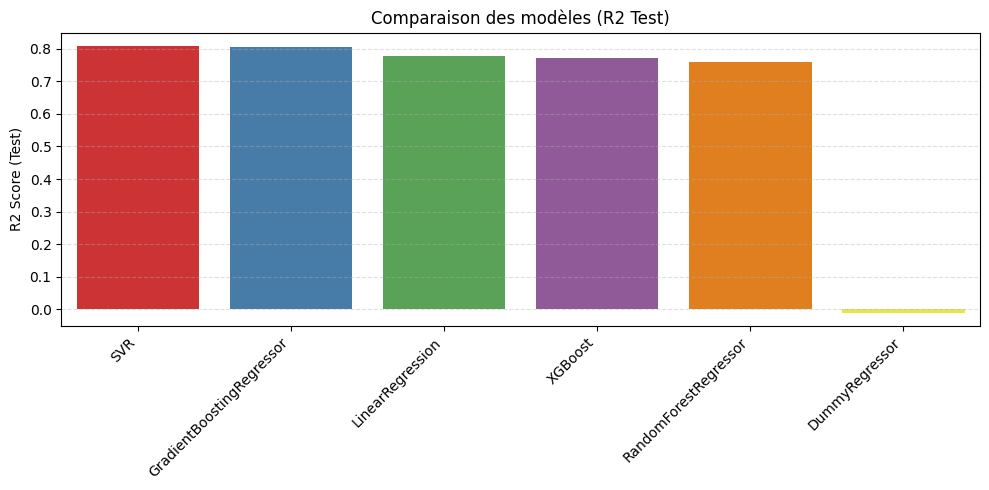

In [34]:
# Tri par meilleur R2
df_sorted = df_results.sort_values("R2 Test", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_sorted, x="Model", y="R2 Test", palette="Set1")

# Comparaison R2 modèle
plt.title("Comparaison des modèles (R2 Test)")
plt.ylabel("R2 Score (Test)")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



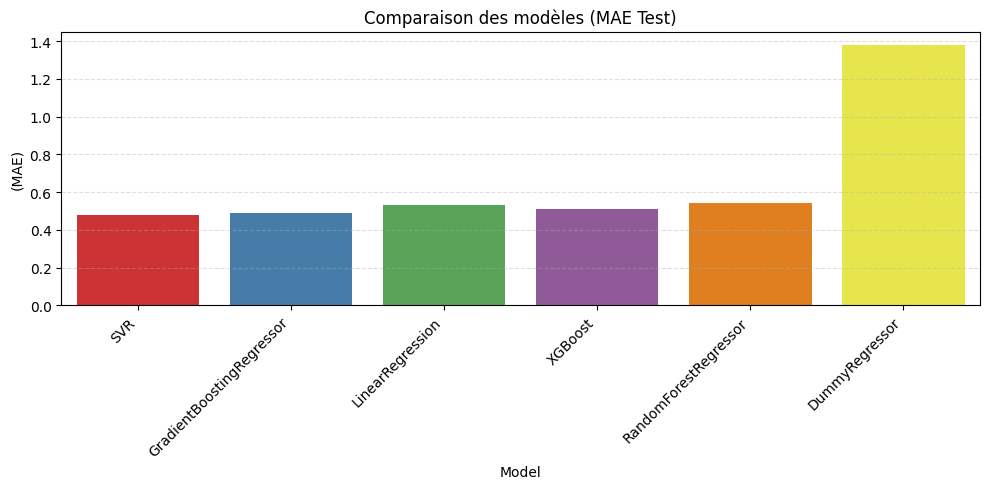

In [35]:
# Comparaison MAE modèle

plt.figure(figsize=(10, 5))
sns.barplot(data=df_sorted, x="Model", y="MAE Test", palette="Set1")
plt.title("Comparaison des modèles (MAE Test)")
plt.ylabel("(MAE)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



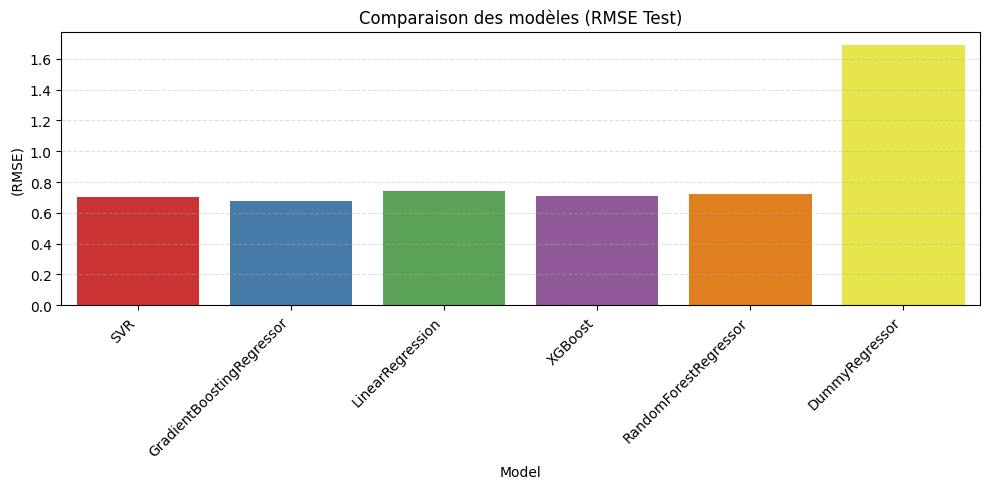

In [36]:
# Comparaison RMSE modèle

plt.figure(figsize=(10, 5))
sns.barplot(data=df_sorted, x="Model", y="RMSE Test", palette="Set1")
plt.title("Comparaison des modèles (RMSE Test)")
plt.ylabel("(RMSE)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

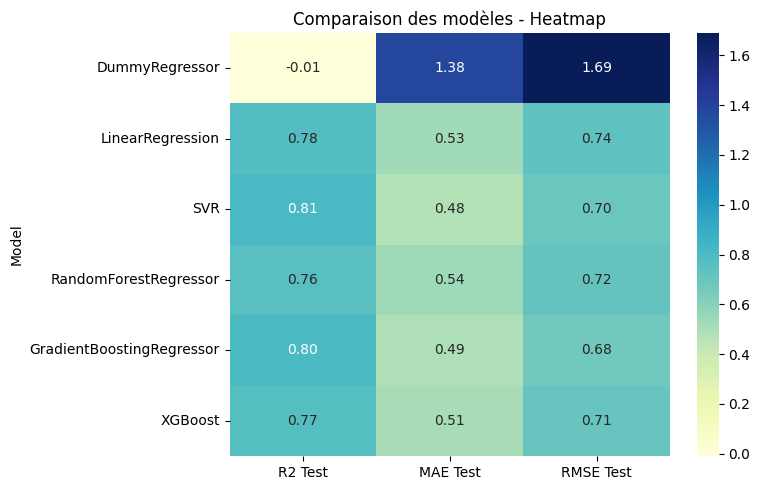

In [37]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_results.set_index("Model")[["R2 Test", "MAE Test", "RMSE Test"]],
    annot=True, fmt=".2f", cmap="YlGnBu"
)
plt.title("Comparaison des modèles - Heatmap")
plt.tight_layout()
plt.show()


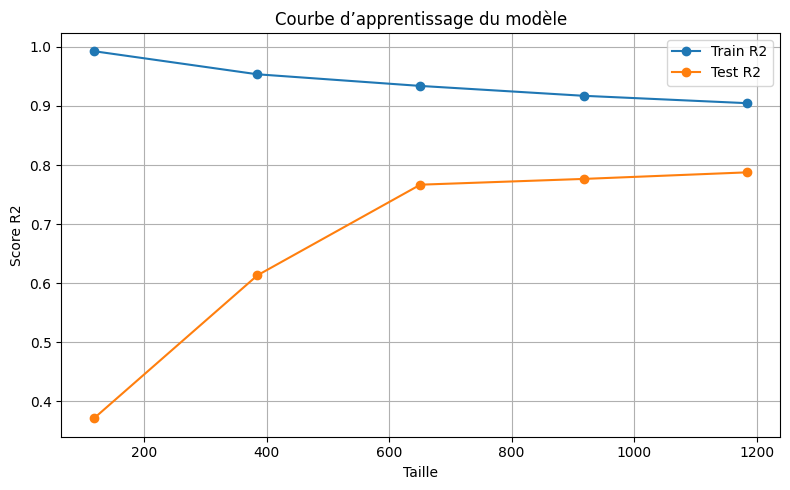

In [38]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train R2", marker='o')
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test R2", marker='o')
plt.xlabel("Taille")
plt.ylabel("Score R2")
plt.title("Courbe d’apprentissage du modèle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


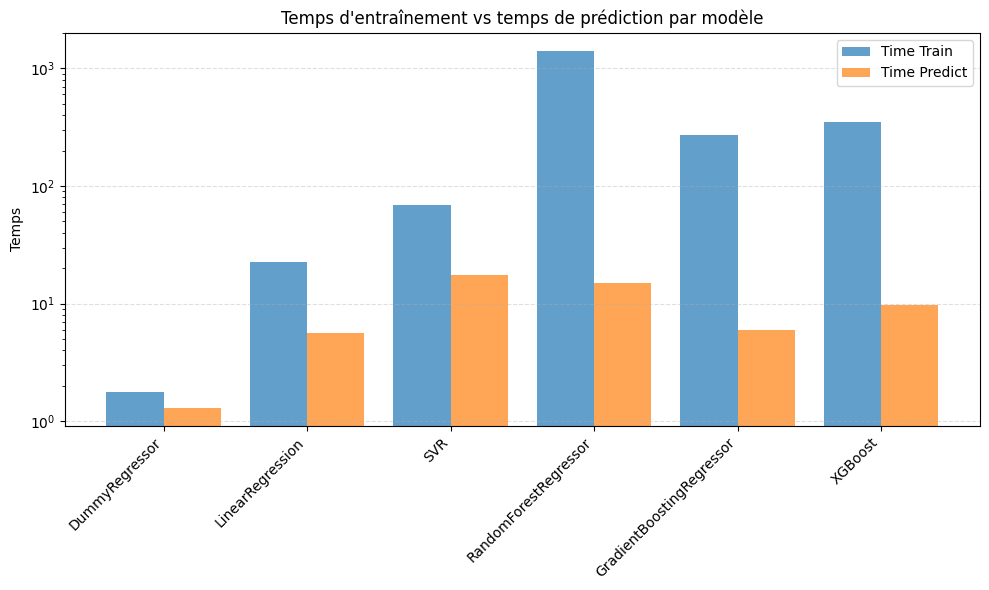

In [39]:
# Comparaison temps entrainement / predict (Cross Validate)

models = df_results["Model"].tolist()
time_train = df_results["Time Train"].tolist() 
time_predict = df_results["Time Predict"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, time_train, width=bar_width, label='Time Train', alpha=0.7)
plt.bar(x + bar_width, time_predict, width=bar_width, label='Time Predict', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Temps")
plt.title("Temps d'entraînement vs temps de prédiction par modèle")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.yscale('log')

plt.tight_layout()
plt.show()

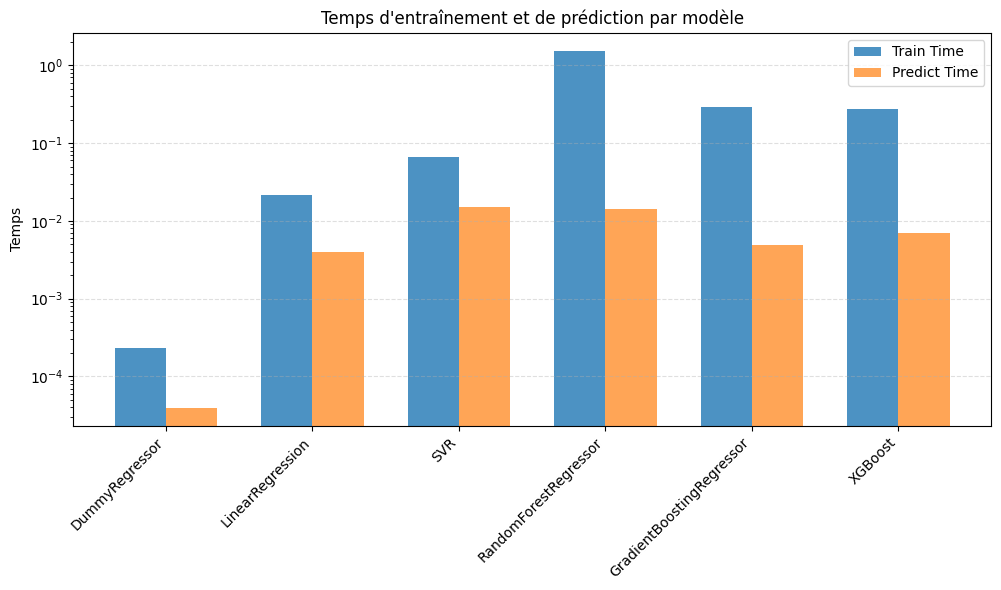

In [40]:
# Comparaison temps entrainement / predict (Fonction)

df_timing = pd.DataFrame(timing_results)

models = df_timing['Model']
train_times = df_timing['Train Time']
predict_times = df_timing['Predict Time']

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, train_times, width=bar_width, label='Train Time', alpha=0.8)
plt.bar(x + bar_width, predict_times, width=bar_width, label='Predict Time', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')
plt.ylabel("Temps")
plt.title("Temps d'entraînement et de prédiction par modèle")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.yscale('log')

plt.show()

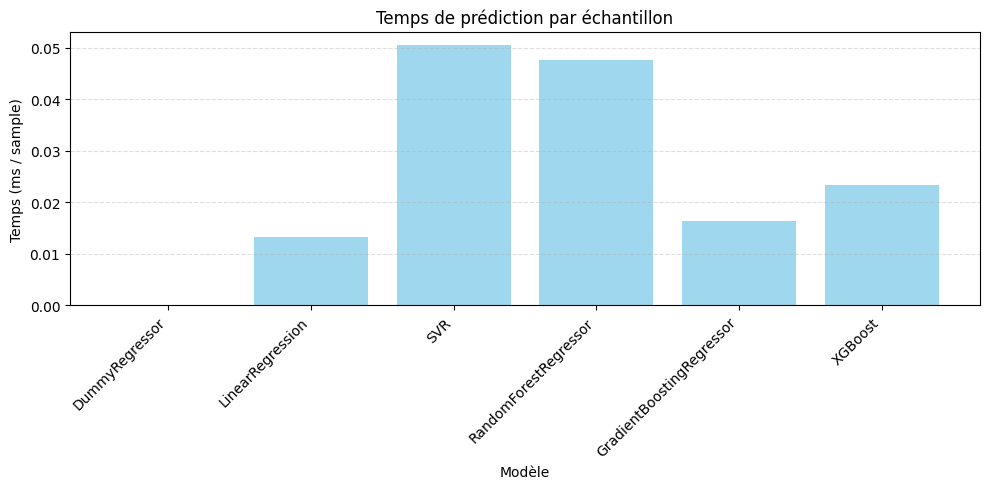

In [41]:
df_timing = pd.DataFrame(timing_results)

models = df_timing["Model"]
predict_time_per_sample = df_timing["Predict Time per Sample"]

plt.figure(figsize=(10, 5))
plt.bar(models, predict_time_per_sample, color='skyblue', alpha=0.8)

plt.title("Temps de prédiction par échantillon")
plt.ylabel("Temps (ms / sample)")
plt.xlabel("Modèle")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()